# Cross technology alignment
In this tutorial, we will show how to use `SLAT` to align spatial dataset from different technologies: 10x Xenium ([Amanda. et al](https://www.biorxiv.org/content/10.1101/2022.10.06.510405v1)) and 10x Visium, which are two complementary spatial technologies. Xenium allows spatially resolving cell types with subcellular resolution but limited in pre-designed gene, while Visium can profile whole picture of transcriptome but lack enough resolution to reveal single cell identity.

You need following files as input:

 * Xenium.h5ad: Xenium dataset, download raw data from [here](https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast) 
 * Visium.h5ad: Visium dataset, download raw data from [here](https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast)
 * TP_Xenium_index.csv: Annotation of triple positive cells in Xenium dataset, download from [here](https://drive.google.com/uc?export=download&id=1Ifhf2UJPklzb-xAJHDDLphar18lb9aIq)
 * TP.csv: (Optional) Annotation of triple positive cells in Visium dataset, just for comparing, download from [here](https://drive.google.com/uc?export=download&id=1zzH9aKPj7ozsjFDAOAiI3YaSlJi2gatb)

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import faiss

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

/ix3/djishnu/alw399/envs/slat2/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /ix3/djishnu/alw399/envs/slat2/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/ix3/djishnu/alw399/envs/slat2/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /ix3/djishnu/alw399/envs/slat2/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

In [3]:
basedir = '/ix/djishnu/shared/djishnu_kor11/training_data_2025'
adata1 = sc.read_h5ad(basedir + '/mouse_kidney_visiumHD.h5ad')
adata2 = sc.read_h5ad(basedir + '/mouse_kidney_13.h5ad')


## Check marker genes
We check expression of marker genes *ERBB2, PGR, ESR1* of triple positive breast tumor in two slices respectively. And we find Xenium have much higher resolution than Visium.
We can find a region enriched triple positive breast tumor cells in Xenium clearly, but it only corresponding a few spots in Visium, which may be neglected easily.

So we decided to use `SLAT` to align two slices and define triple positive breast tumor in Visium.

Here we load the manually labeled triple positive cells in Xenium dataset

In [4]:
adata1.X = adata1.layers['raw_count']
adata2.X = adata2.layers['raw_count']

## Run SLAT
**Note**: we set different size of *k* to ensure that two GCNs have similar receptive fields in spatial

In [5]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 113894 edges, 10000 cells.
11.3894 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 94277 edges, 8509 cells.
11.079680338465154 neighbors per cell on average.


In [6]:
edges, features = load_anndatas([adata1, adata2], feature='Harmony')
embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=6, hidden_size=4096)

Use Harmony feature to format graph


/ix3/djishnu/alw399/envs/slat2/lib/python3.11/site-packages/scSLAT/model/loaddata.py:239: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_all = adatas[0].concatenate(adatas[1], join=join)  # join can not be 'outer'!


Harmony is using GPU!
Use GPU mode.
	Initialization is completed.
	Completed 1 / 30 iteration(s).
	Completed 2 / 30 iteration(s).
Reach convergence after 2 iteration(s).
Choose GPU:0 as device
Running
Training model time: 0.89


In [7]:
best, index, distance = spatial_match(
    features[::-1], adatas=[adata2,adata1], 
    reorder=False, 
    # top_n=200, 
    smooth_range=200
)

In [8]:
adata1.obs['leiden'] = adata1.obs['cell_type']

In [9]:
adata2.obs['leiden'] = adata2.obs['cell_type']

In [30]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'leiden':adata1.obs['leiden']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'leiden':adata2.obs['leiden']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

## Visualize alignment

dataset1: 7 cell types; dataset2: 7 cell types; 
                    Total :7 celltypes; Overlap: 7 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 10000


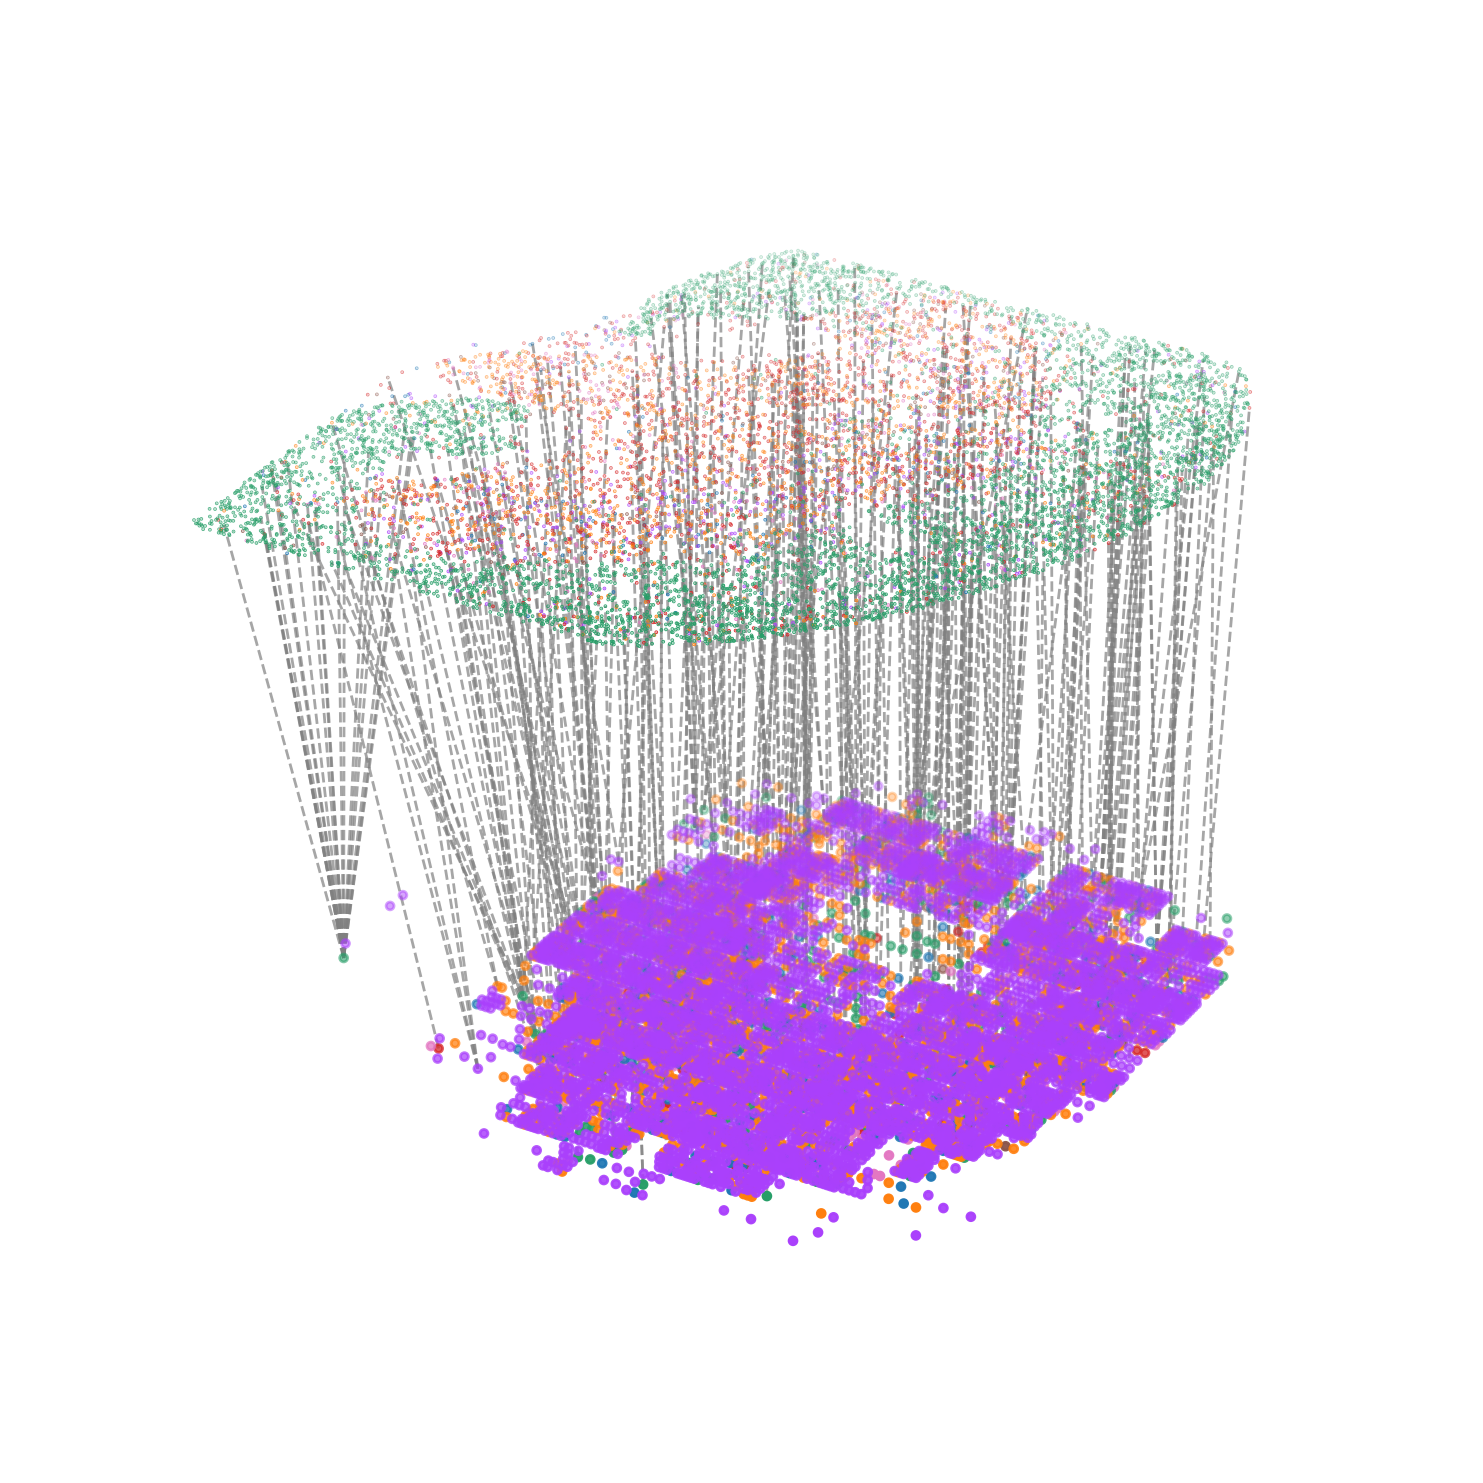

In [11]:
multi_align = match_3D_multi(adata2_df, adata1_df, matching, meta='leiden',
                            scale_coordinate=True, subsample_size=300)

multi_align.draw_3D(size=[13, 9.5], line_width=1 ,point_size=[8,0.1], show_error=False, hide_axis=True)

In [12]:
adata1.obs.cell_type.value_counts()

Epithelial             5437
Mesenchymal_Stromal    1723
Endothelial            1369
Myeloid                 537
T                       381
NK                      327
B                       226
Name: cell_type, dtype: int64

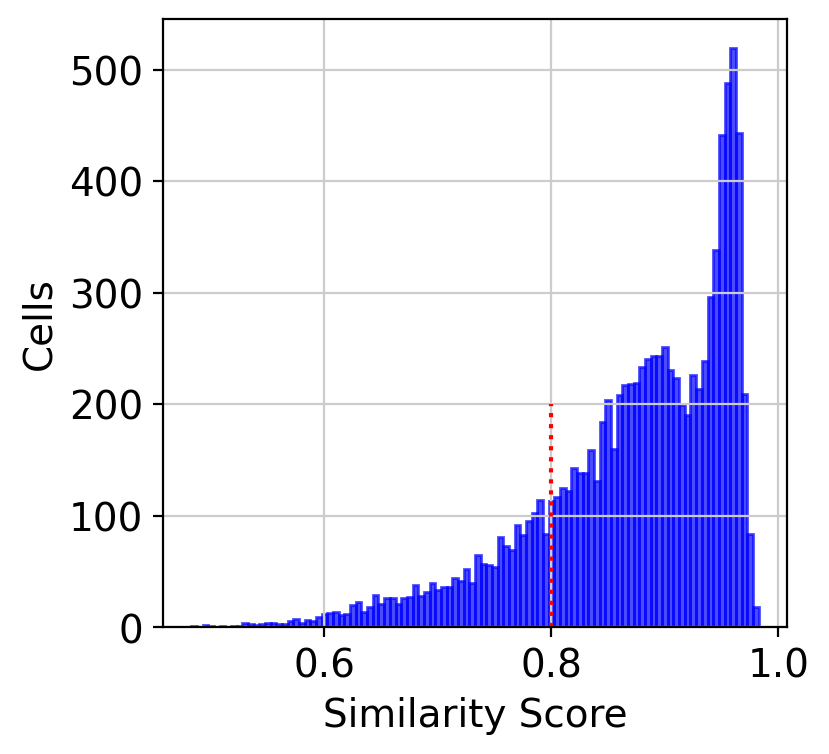

In [13]:
%matplotlib inline
hist(best_match, cut=0.8)

In [14]:
adata1_df['target_celltype'] = adata2_df.iloc[matching[1,:],:]['leiden'].to_list()
matching_table = adata1_df.groupby(['leiden','target_celltype']).size().unstack(fill_value=0)

Sankey(matching_table, prefix=['mouse_kidney_test','mouse_kidney_train'])

In [24]:
matching.shape

(2, 10000)

In [31]:
matching = pd.DataFrame(matching).T

In [35]:
matching[1].map({i: cell for i, cell in enumerate(adata2.obs.index)})

0       AAGATAGTCACTGGTA-13
1       CCAAGCGTCCTGATAG-13
2       TGTTCATGTCCCTCAT-13
3       GAGCCTGGTTGGCCTG-13
4       GTGCTGGAGTGCTAGG-13
               ...         
9995    TATGTTCTCGGTGTTA-13
9996    AGTTAGCAGCGCAATG-13
9997    GTGGAAGGTGCCCTTT-13
9998    AGGGCTCGTATCATGC-13
9999    CAGCAGCGTCCCTCAT-13
Name: 1, Length: 10000, dtype: object

In [34]:
matching[0].map({i: cell for i, cell in enumerate(adata1.obs.index)})

0        35131
1       261116
2       840279
3        37309
4         4693
         ...  
9995    315054
9996    301595
9997    313083
9998    176196
9999     79770
Name: 0, Length: 10000, dtype: object

In [36]:
matching[1] = matching[1].map({i: cell for i, cell in enumerate(adata2.obs.index)})
matching[0] = matching[0].map({i: cell for i, cell in enumerate(adata1.obs.index)})
matching.set_index(0, inplace=True)
matching.rename(columns={1: 'reference_cell'}, inplace=True)
matching

,reference_cell
0,
35131,AAGATAGTCACTGGTA-13
261116,CCAAGCGTCCTGATAG-13
840279,TGTTCATGTCCCTCAT-13
37309,GAGCCTGGTTGGCCTG-13
4693,GTGCTGGAGTGCTAGG-13
...,...
315054,TATGTTCTCGGTGTTA-13
301595,AGTTAGCAGCGCAATG-13
313083,GTGGAAGGTGCCCTTT-13


In [37]:
matching.to_csv('matching_13_HD.csv')

In [38]:
matching['cell_type'] = adata1.obs.index.map(adata1.obs['cell_type'].to_dict())
matching['cell_type'].value_counts()

Epithelial             5437
Mesenchymal_Stromal    1723
Endothelial            1369
Myeloid                 537
T                       381
NK                      327
B                       226
Name: cell_type, dtype: int64

In [39]:
matching

,reference_cell,cell_type
0,,
35131,AAGATAGTCACTGGTA-13,Epithelial
261116,CCAAGCGTCCTGATAG-13,Mesenchymal_Stromal
840279,TGTTCATGTCCCTCAT-13,Epithelial
37309,GAGCCTGGTTGGCCTG-13,Myeloid
4693,GTGCTGGAGTGCTAGG-13,Epithelial
...,...,...
315054,TATGTTCTCGGTGTTA-13,Epithelial
301595,AGTTAGCAGCGCAATG-13,Epithelial
313083,GTGGAAGGTGCCCTTT-13,Endothelial


In [42]:
adata1.obs['matched_cell_type'] = matching.loc[adata1.obs.index, 'cell_type']

/tmp/ipykernel_3591/389214827.py:1: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



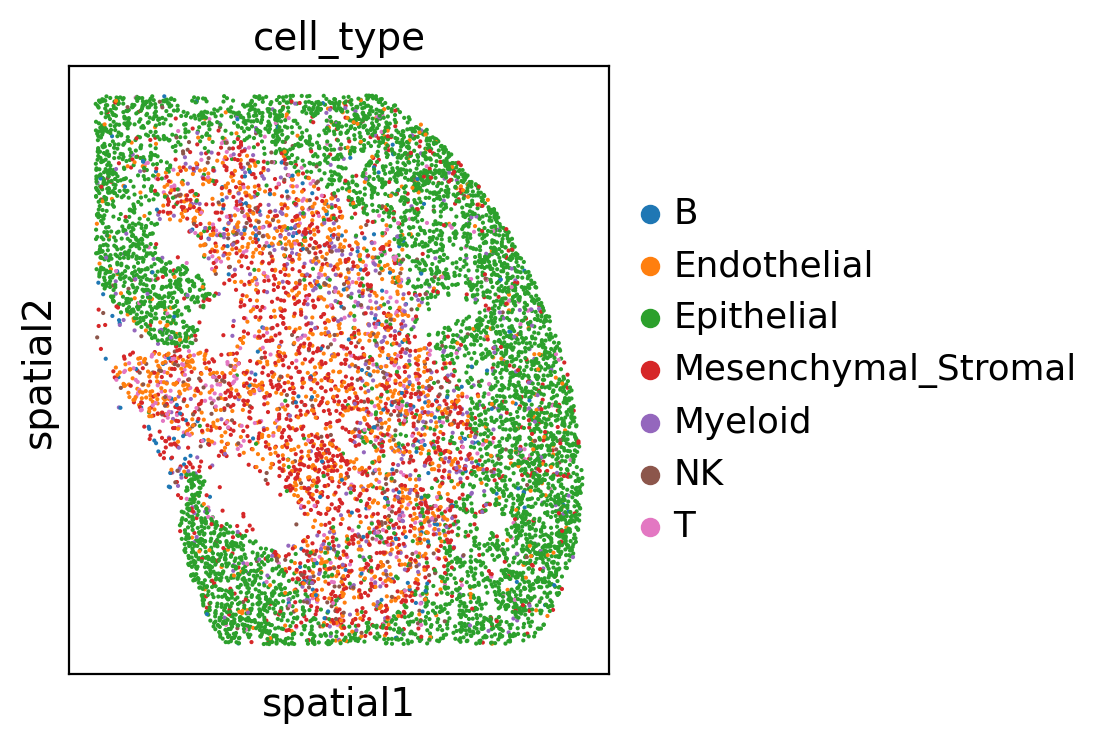

/tmp/ipykernel_3591/389214827.py:2: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



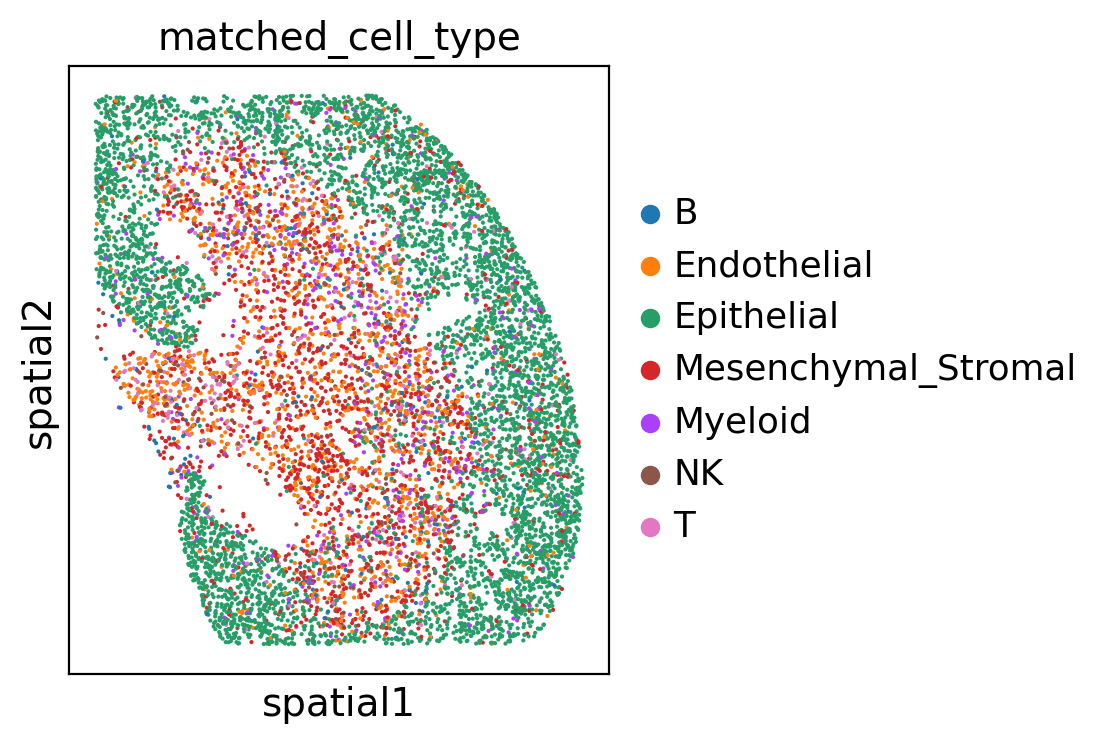

/tmp/ipykernel_3591/389214827.py:4: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



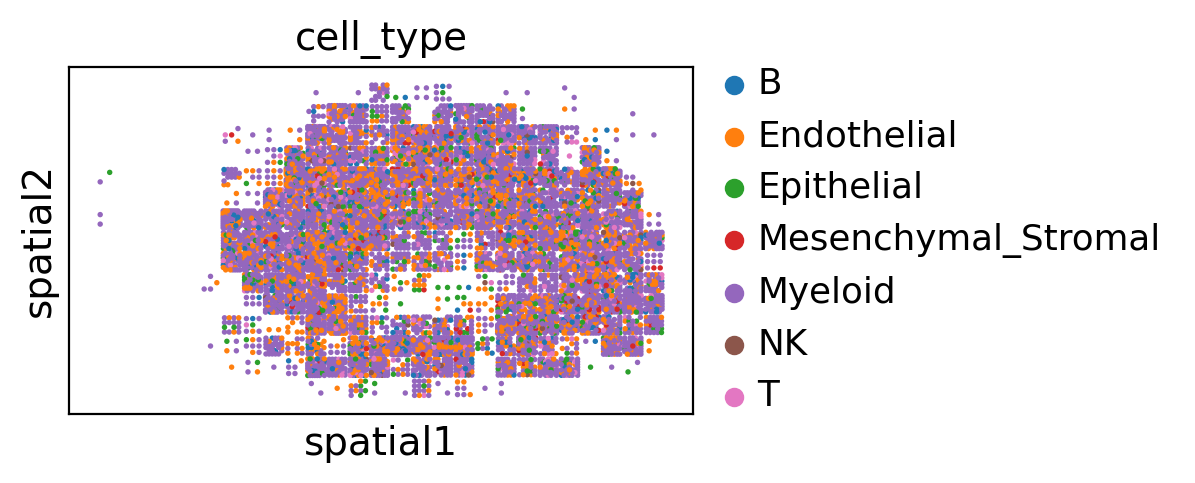

In [43]:
sc.pl.spatial(adata1, color='cell_type', spot_size=20)
sc.pl.spatial(adata1, color='matched_cell_type', spot_size=20)

sc.pl.spatial(adata2, color='cell_type', spot_size=20)
